# Chicory segmentation using a YOLOv8 model

For the segmentation of chicory, we use a YOLOv8 model for segmentation purposes. The data was created and labeled by Captic. The labels contains the bounding box and the segmentation masks of the complete chicory and the loaf. The data was converted to YOLO format and to COCO format for visualisation. 

In [5]:
# Imports
import os
import ultralytics
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

## Data analysis

The data folder contains a folder with images and a folder with labels in the YOLO format. This format has a .txt file for every image with one line for each annotation. Each line contains the image class, the normalized bounding box coordinates [x_center, y_center, width, height], and the normalized coordinates of polygon that defines the segmentation mask. We also use a .json file with all labels in COCO format for visualization of the labels.

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


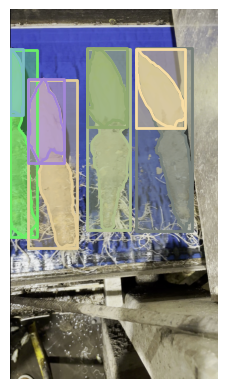

In [6]:
# Create a COCO object
coco = COCO('../../data/chicory_data_segmentation/witloof_dataset_coco.json')

# Get the annotations for this image
annotations = coco.loadAnns(coco.getAnnIds(imgIds=1))

# Get the image info
img_info = coco.loadImgs(1)[0]
height, width = img_info['height'], img_info['width']
file_name = img_info['file_name'].split('/')[-1]
img_path = os.path.join('../../data/chicory_data_segmentation/images/', file_name)
image = plt.imread(img_path)

# Load and display instance annotations
plt.imshow(image); plt.axis('off')
coco.showAnns(annotations, draw_bbox=True)
plt.show()

# Data preprocessing

For a proper pipeline, we will split our total dataset into a training, validation, and testset. De model gets trained on images from the training set. After each batch, the model is validated on the validation set. After training, we can evaluate the final model on the testset. The below command creates three autosplit .txt files that contain the paths to the images of the corresponding dataset for training, validation, and testing.

In [7]:
# Split data in 80% training, 10% validation, and 10% test sets
ultralytics.data.utils.autosplit(path='../../data/chicory_data_segmentation/images', weights=(0.8, 0.1, 0.1), annotated_only=False)

Autosplitting images from ..\..\data\chicory_data_segmentation\images


100%|██████████| 288/288 [00:00<00:00, 5751.42it/s]


## Model training

In the next step, we will train our model. The model that we use is a pretrained YOLOv8n-seg model that was trained on the COCO dataset. We use the Ultralytics API for the training and validation phase. More info on: https://docs.ultralytics.com/tasks/pose/. All model parameters are logged during training, all parameters can be visualized using Tensorboard which will be activated below. 

In [10]:
# Load a YOLOv8 model for segmentation
model = YOLO('yolov8n-seg.yaml').load('yolov8n-seg.pt')  # build from YAML and transfer weights

# Training params
epochs = 20 # All data is sent 'epoch' times through the network
image_size = 640 # All images are resized to this size before entering the network

# Train the model
results = model.train(data='../../data/chicory_data_segmentation/witloof_dataset.yaml', epochs=epochs, imgsz=image_size)

Transferred 417/417 items from pretrained weights
Ultralytics YOLOv8.1.14 🚀 Python-3.10.11 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A500 Laptop GPU, 4096MiB)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=../../data/chicory_data_segmentation/witloof_dataset.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

100%|██████████| 6.23M/6.23M [00:01<00:00, 4.99MB/s]


AMP: checks passed ✅


train: Scanning C:\Users\matth\OneDrive - KU Leuven\Python_Projects\machine_vision\data\chicory_data_segmentation\labels... 92 images, 133 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:00<00:00, 497.59it/s]

train: New cache created: C:\Users\matth\OneDrive - KU Leuven\Python_Projects\machine_vision\data\chicory_data_segmentation\labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\matth\OneDrive - KU Leuven\Python_Projects\machine_vision\data\chicory_data_segmentation\labels... 5 images, 27 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<00:00, 655.96it/s]

val: New cache created: C:\Users\matth\OneDrive - KU Leuven\Python_Projects\machine_vision\data\chicory_data_segmentation\labels.cache


Plotting labels to ..\runs\segment\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\runs\segment\train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.05G      1.051      4.194      3.164      1.205          6        640: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

                   all         32         55    0.00564      0.981     0.0737     0.0516    0.00545      0.946     0.0684     0.0274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.03G     0.8143      1.924      1.947      1.029         13        640: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         32         55     0.0122      0.817      0.101     0.0663    0.00701      0.429     0.0843     0.0407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.18G     0.7772      1.632      1.651      1.009         12        640: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         32         55      0.579      0.339      0.175      0.129       0.57      0.284      0.167      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.14G     0.7124      1.445      2.669     0.9317          0        640: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         32         55      0.232      0.458      0.211      0.174      0.224      0.405      0.203      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.15G     0.7366      1.591      1.561      1.002          8        640: 100%|██████████| 15/15 [00:07<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         32         55      0.163      0.779      0.186      0.147      0.161      0.775       0.18      0.133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.15G     0.6947      1.518       2.75     0.9403          0        640: 100%|██████████| 15/15 [00:07<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         32         55      0.151      0.742      0.195      0.157      0.153      0.768      0.186      0.133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.13G     0.7642      1.502      1.526     0.9994         27        640: 100%|██████████| 15/15 [00:08<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         32         55      0.178      0.919      0.208      0.164      0.168      0.837      0.203      0.141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.22G     0.7156      1.568      1.441     0.9703         24        640: 100%|██████████| 15/15 [00:08<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         32         55      0.176      0.927      0.203      0.164      0.172      0.909      0.198      0.146



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20       3.1G     0.7156      1.404      1.546     0.9775          6        640: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         32         55      0.177      0.891      0.237      0.187      0.166      0.855       0.23      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.11G     0.6964      1.367      2.702     0.9063          0        640: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         32         55      0.179      0.939      0.221      0.183      0.173      0.892       0.21      0.155


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.92G     0.6491      1.132      2.363     0.9195          0        640: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         32         55      0.168      0.816        0.2       0.15      0.154      0.745      0.169      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.88G     0.6641      1.099      1.602     0.9865          7        640: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         32         55      0.181      0.857      0.203      0.163      0.172        0.8      0.195      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.89G     0.6086      1.011      2.286     0.8973          0        640: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         32         55      0.171      0.927      0.195       0.16      0.167      0.909      0.193      0.134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.88G     0.5864     0.9754      2.424     0.8891          0        640: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         32         55      0.171      0.928      0.189      0.155      0.164      0.892       0.17      0.122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.91G     0.6242      1.168      1.494     0.9407         10        640: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         32         55      0.169      0.928      0.179      0.153      0.162      0.905       0.17      0.125



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.78G     0.5754     0.9292      1.441     0.9321          9        640: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         32         55      0.175      0.928      0.184      0.157      0.173       0.91      0.181      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.88G      0.526      0.837      2.327     0.8779          0        640: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         32         55      0.175      0.892      0.193      0.159      0.168      0.858      0.181      0.139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.89G     0.5777     0.9279      1.376     0.9245          6        640: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         32         55      0.177      0.946      0.181      0.152       0.17      0.911      0.173      0.132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.87G      0.542     0.9171      1.377      0.916          9        640: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         32         55      0.179      0.982      0.182      0.154      0.179      0.982       0.18      0.134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.84G     0.5034     0.8285      1.342     0.9083         13        640: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         32         55      0.179      0.928      0.184       0.16      0.179      0.928      0.182      0.137



20 epochs completed in 2.440 hours.
Optimizer stripped from ..\runs\segment\train3\weights\last.pt, 6.8MB
Optimizer stripped from ..\runs\segment\train3\weights\best.pt, 6.8MB

Validating ..\runs\segment\train3\weights\best.pt...
Ultralytics YOLOv8.1.14 🚀 Python-3.10.11 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A500 Laptop GPU, 4096MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258454 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


                   all         32         55      0.177      0.891      0.236      0.187      0.166      0.855      0.229      0.149
               chicory         32         28      0.172      0.893      0.253      0.184      0.155      0.821      0.239      0.129
                  loaf         32         27      0.182      0.889       0.22       0.19      0.178      0.889       0.22      0.169
Speed: 0.2ms preprocess, 7.7ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to ..\runs\segment\train3


## Model validation

After training, we load the best model and perform a validation step on the test data. Afterwards, we show some predictions. 

In [ ]:
# Load a pretrained YOLOv8n model
model = YOLO('../runs/segment/train/weights/best.pt')

In [ ]:
# Validate the model
metrics = model.val(split='test')

In [ ]:
# Predict with the model
results = model('../../data/chicory_data_segmentation/autosplit_test.txt', stream=True)  # predict on an image

# Plot results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    plt.imshow(im)
    plt.show()

<Figure size 640x480 with 1 Axes>

image 1/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__0300.jpg: 640x384 2 chicorys, 1 loaf, 163.8ms


<Figure size 640x480 with 1 Axes>

image 2/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__0480.jpg: 640x384 3 chicorys, 2 loafs, 144.9ms


<Figure size 640x480 with 1 Axes>

image 3/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__0510.jpg: 640x384 2 chicorys, 1 loaf, 42.6ms


<Figure size 640x480 with 1 Axes>

image 4/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__0570.jpg: 640x384 5 chicorys, 1 loaf, 41.9ms


<Figure size 640x480 with 1 Axes>

image 5/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__0840.jpg: 640x384 3 chicorys, 42.8ms


<Figure size 640x480 with 1 Axes>

image 6/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__0870.jpg: 640x384 4 chicorys, 2 loafs, 40.6ms


<Figure size 640x480 with 1 Axes>

image 7/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__1470.jpg: 640x384 3 chicorys, 3 loafs, 42.0ms


<Figure size 640x480 with 1 Axes>

image 8/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__1650.jpg: 640x384 3 chicorys, 9.3ms


<Figure size 640x480 with 1 Axes>

image 9/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__1860.jpg: 640x384 4 chicorys, 9.5ms


<Figure size 640x480 with 1 Axes>

image 10/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__2340.jpg: 640x384 5 chicorys, 8.5ms


<Figure size 640x480 with 1 Axes>

image 11/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__2430.jpg: 640x384 3 chicorys, 9.0ms


<Figure size 640x480 with 1 Axes>

image 12/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__2700.jpg: 640x384 5 chicorys, 2 loafs, 7.7ms


<Figure size 640x480 with 1 Axes>

image 13/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__2820.jpg: 640x384 4 chicorys, 1 loaf, 8.6ms


<Figure size 640x480 with 1 Axes>

image 14/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__2850.jpg: 640x384 4 chicorys, 8.5ms


<Figure size 640x480 with 1 Axes>

image 15/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__3420.jpg: 640x384 (no detections), 8.5ms


<Figure size 640x480 with 1 Axes>

image 16/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof1__3690.jpg: 640x384 2 chicorys, 1 loaf, 10.0ms


<Figure size 640x480 with 1 Axes>

image 17/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__0060.jpg: 640x384 3 chicorys, 1 loaf, 8.1ms


<Figure size 640x480 with 1 Axes>

image 18/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__0210.jpg: 640x384 4 chicorys, 1 loaf, 9.0ms


<Figure size 640x480 with 1 Axes>

image 19/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__0570.jpg: 640x384 4 chicorys, 2 loafs, 9.0ms


<Figure size 640x480 with 1 Axes>

image 20/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__0720.jpg: 640x384 3 chicorys, 2 loafs, 9.0ms


<Figure size 640x480 with 1 Axes>

image 21/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__0810.jpg: 640x384 4 chicorys, 9.0ms


<Figure size 640x480 with 1 Axes>

image 22/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__1530.jpg: 640x384 2 chicorys, 9.0ms


<Figure size 640x480 with 1 Axes>

image 23/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__1650.jpg: 640x384 4 chicorys, 9.8ms


<Figure size 640x480 with 1 Axes>

image 24/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__2730.jpg: 640x384 4 chicorys, 9.0ms


<Figure size 640x480 with 1 Axes>

image 25/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__2850.jpg: 640x384 1 chicory, 1 loaf, 9.6ms


<Figure size 640x480 with 1 Axes>

image 26/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__3270.jpg: 640x384 1 chicory, 9.1ms


<Figure size 640x480 with 1 Axes>

image 27/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__3840.jpg: 640x384 (no detections), 9.0ms


<Figure size 640x480 with 1 Axes>

image 28/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__3870.jpg: 640x384 (no detections), 9.0ms


<Figure size 640x480 with 1 Axes>

image 29/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__3900.jpg: 640x384 (no detections), 9.0ms


<Figure size 640x480 with 1 Axes>

image 30/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__4080.jpg: 640x384 3 chicorys, 2 loafs, 9.2ms


<Figure size 640x480 with 1 Axes>

image 31/31 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\tetra_mv4qc\mv4qc-usecase-2\notebooks\..\data\data_captic\images\witfloof2__4530.jpg: 640x384 5 chicorys, 1 loaf, 8.6ms
Speed: 2.4ms preprocess, 23.7ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 384)
